# Hierarchical Linear Regression (Pigs dataset)

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import statsmodels.api as sm
import warnings
import xarray as xr
warnings.simplefilter('ignore')

SEED = 94980
plt.style.use('bmh')
np.random.seed(SEED)

We'll use a dataset included with `statsmodels` containing [the growth curve of pigs](https://www.rdocumentation.org/packages/doBy/versions/4.6-2/topics/data-dietox). 

This model aims to analyse how pig weight changes over time. We know each pig's growth is unique; at the same time, these pigs belong to the same species/population, so there also lies some similarity among them. Hierarchical models are beneficial for these kinds of problems. 

This notebook will demonstrate how to perform a Bayesian hierarchical linear regression in Bambi and PyMC.

## Load data & EDA

In [2]:
# Load up data from statsmodels
df = sm.datasets.get_rdataset("dietox", "geepack").data
df.describe()

,Pig,Litter,Start,Weight,Feed,Time
count,861.000000,861.000000,861.000000,861.000000,789.000000,861.000000
mean,6238.319396,12.135889,25.672701,60.725769,80.728645,6.480836
std,1323.845928,7.427252,3.624336,24.978881,52.877736,3.444735
min,4601.000000,1.000000,15.000000,15.000000,3.300003,1.000000
25%,4857.000000,5.000000,23.799990,38.299990,32.800003,3.000000
50%,5866.000000,11.000000,25.700000,59.199980,74.499996,6.000000
75%,8050.000000,20.000000,27.299990,81.199950,123.000000,9.000000
max,8442.000000,24.000000,35.399990,117.000000,224.500000,12.000000


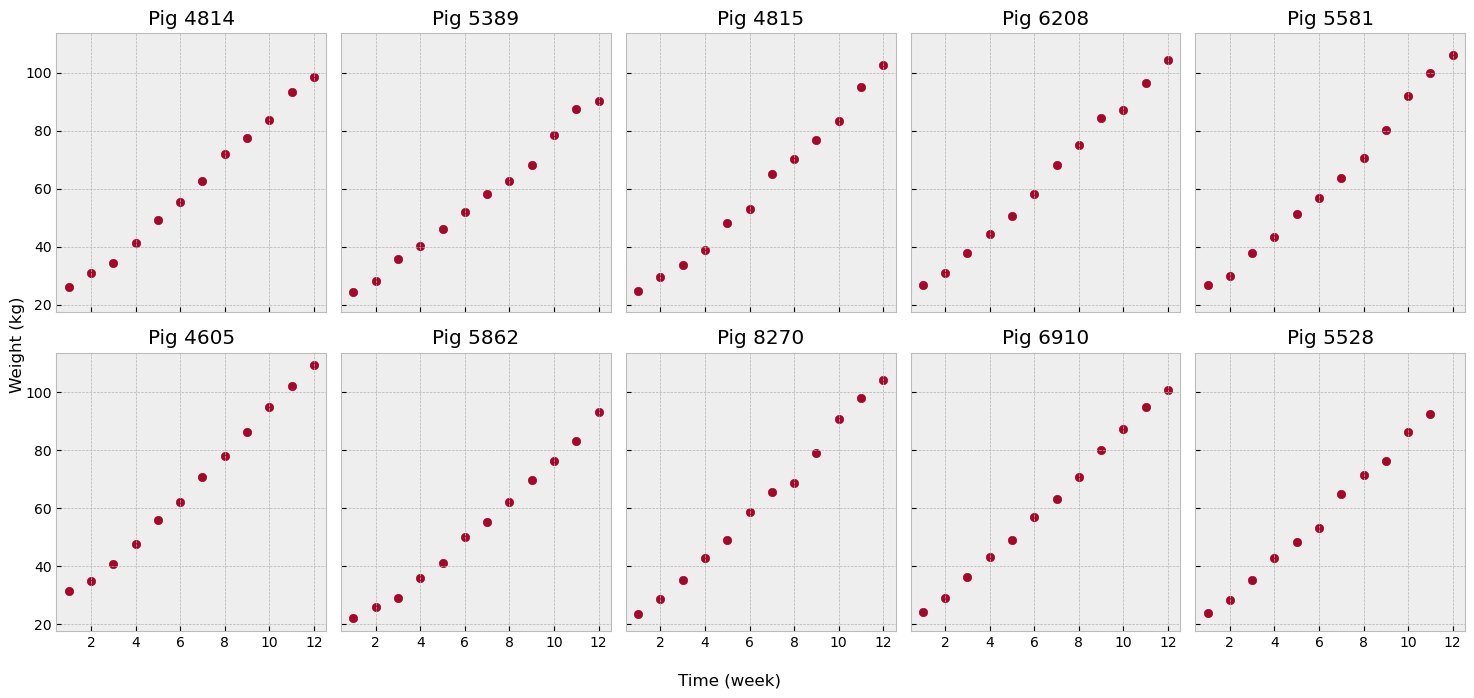

In [3]:
# Time vs Weight for 10 random pigs

random_pigs = np.random.choice(df['Pig'].unique(), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(15,7), sharex=True, sharey=True)
axes = axes.flatten()
for i, pig_id in enumerate(random_pigs):
    pig_data = df[df['Pig'] == pig_id]
    axes[i].scatter(pig_data['Time'], pig_data['Weight'], color='C1')
    axes[i].set_title(f'Pig {pig_id}')
    axes[i].set_xticks([q+1 for q in range(1,13,2)])
fig.supxlabel('Time (week)')
fig.supylabel('Weight (kg)')
plt.tight_layout()
plt.show()

We'll use 3 parameters for our model: `Pig` (unique identifier for each pig), `Time` (time of measurement in weeks), and `Weight` (recorded value at each week, our observed variable).

From the plot, the Time vs Weight appears to follow a linear trend, but the slope and intercept vary pig by pig. So, we'll estimate a model that allows varying intercepts and slopes for time for each pig.

## Model Definition

$$
Y_i = \alpha_i + \beta_i X + \epsilon
$$

where, 

$$
\begin{aligned}
\alpha_i &= \alpha_0 + \alpha_{1, i} \\
\beta_i &= \beta_0 + \beta_{1, i}
\end{aligned}
$$

So the first equation can be further diluted as,

$$
\begin{aligned}
Y_i = \alpha_0 + \alpha_{1, i} + [\beta_0 + \beta_{1, i}]X + \epsilon \\
Y_i = \alpha_0 + \beta_0 X + \alpha_{1, i} + \beta_{1, i} X + \epsilon
\end{aligned}
$$

where $\alpha_0$ and $\beta_0$ are the usual common intercept and slope you find in a linear regression. $\alpha_{1, i}$ and $\beta_{1, i}$ are the group specific components for the pig $i$, influencing the intercept and the slope respectively. Finally $\epsilon$ is the random error we always see in these models, assumed to be Gaussian with mean 0. Note that here we use "common" and "group specific" effects to denote what in many fields are known as "fixed" and "random" effects, respectively.

### PyMC Model

We will first define a PyMC model with the same mathematical conventions used before for better understanding. All the priors were set based on intuition from EDA and summary stats, with larger standard deviations to make the distributions wider and weakly informative.

We used the `coords` argument inside `pm.Model()` to add dimensionality for our model. Also, notice that we passed the `dims` argument only for Group-level terms. By doing so, we made those terms vectors instead of scalars. For example, `α1_offset` will have 72 (Total number of pigs) independent $\mathcal{N}(0,1)$ distributions. The same can be achieved with the `shape` argument, but using `dims` enhances compatibility with ArviZ.

In [4]:
pig, n_pig = df.Pig.factorize()
coords = {'Pig': n_pig}

In [5]:
with pm.Model(coords = coords) as pymc_model:
    # Common-level effects
    α0 = pm.Normal('α0', mu = 60, sigma = 75)
    β0 = pm.Uniform('β0', lower = 1, upper = 12)

    # Hyperpriors
    α1_offset = pm.Normal('α1_offset', mu = 0, sigma = 1, dims = 'Pig')
    α1_sigma = pm.HalfNormal('α1_sigma', sigma = 75)
    β1_offset = pm.Normal('β1_offset', mu = 0, sigma = 1, dims = 'Pig')
    β1_sigma = pm.HalfNormal('β1_sigma', sigma = 12)

    # Group-level effects
    α1 = pm.Deterministic('α1', α1_offset*α1_sigma, dims = 'Pig')
    β1 = pm.Deterministic('β1', β1_offset*β1_sigma, dims = 'Pig')

    # Random error
    σ = pm.HalfStudentT('σ', nu = 4, sigma = 25)

    # Likelihood
    μ = pm.Deterministic('μ', α0 + β0*df.Time + α1[pig] + β1[pig]*df.Time)

    # Observed variable
    Y = pm.Normal('Weight', mu = μ, sigma = σ, observed = df.Weight)

    # Sampling
    pymc_idata = pm.sample(draws = 2000, random_seed = SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α0, β0, α1_offset, α1_sigma, β1_offset, β1_sigma, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


Let's generate a prior plot for `pymc_model` to check out the range of values these parameters take before sampling.

Sampling: [Weight, α0, α1_offset, α1_sigma, β0, β1_offset, β1_sigma, σ]
Sampling: [Weight]


Output()

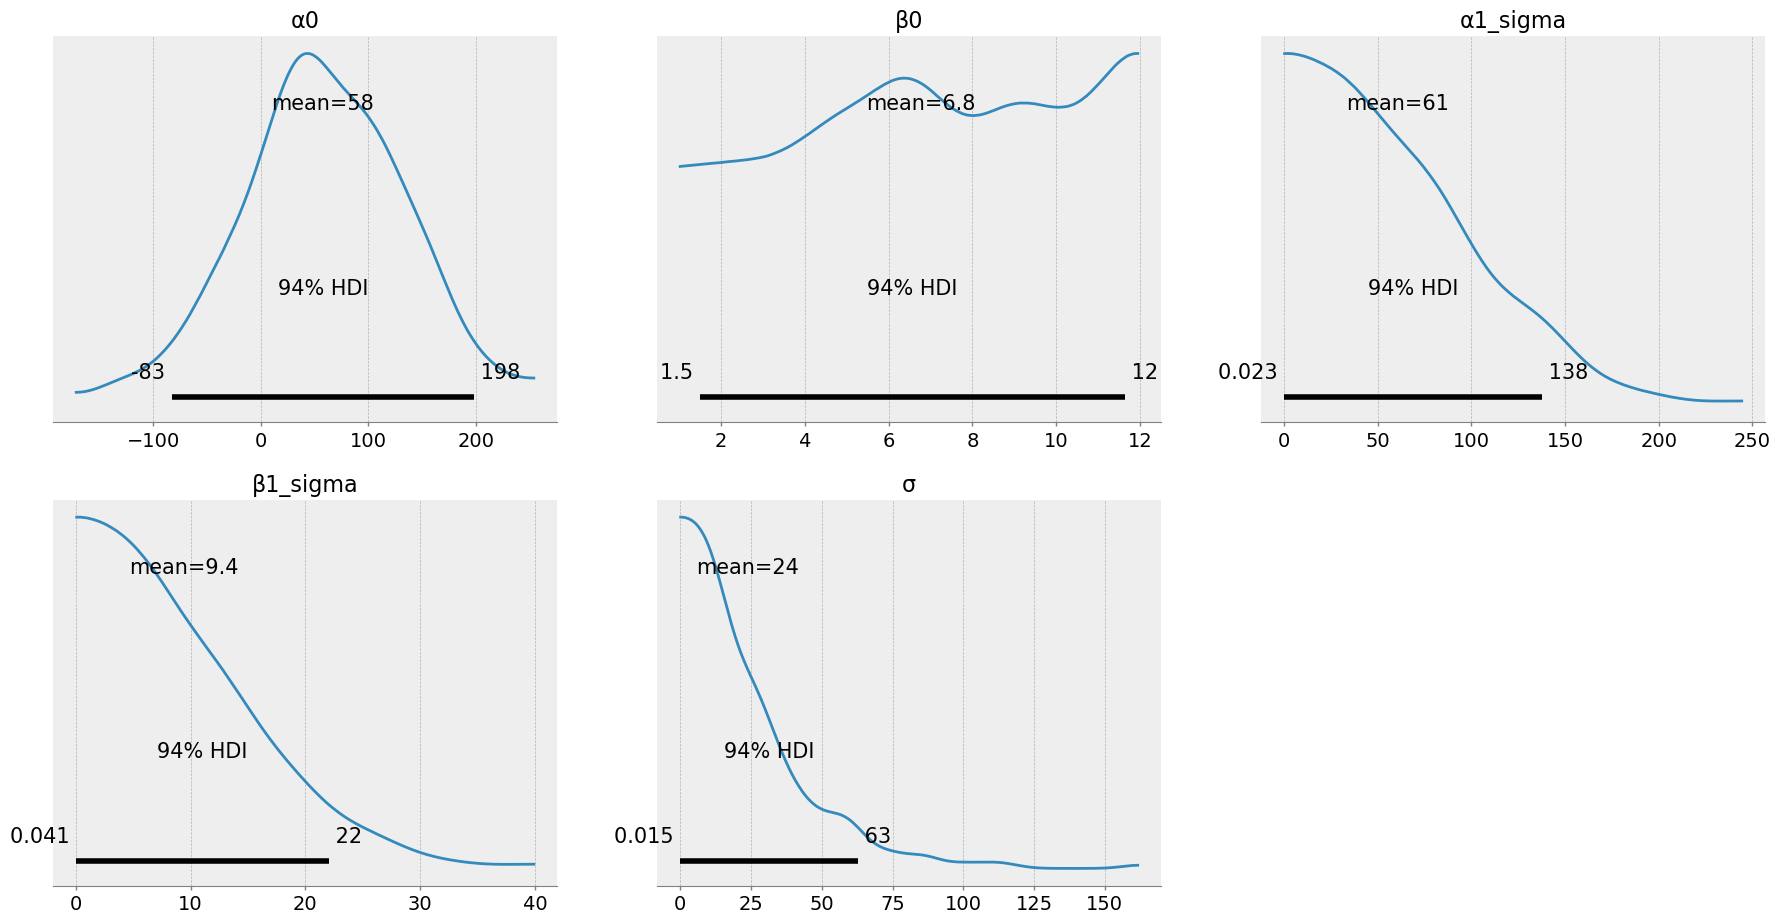

In [6]:
var_names = [i.name for i in pymc_model.unobserved_RVs 
             if i not in pymc_model.deterministics and '_offset' not in i.name]

with pymc_model:
    pymc_idata.extend(pm.sample_prior_predictive(random_seed = SEED))
    pymc_idata.extend(pm.sample_posterior_predictive(pymc_idata, random_seed = SEED))

az.plot_posterior(pymc_idata, group = 'prior', var_names = var_names);
# Keep in mind it's PRIOR PLOT, but i used plot_posterior function from ArviZ for convenience (lazy, i know!).

### Bambi Model

In Bambi, We use the formula syntax to specify the model. Previously in PyMC, We specified common and group specific components separately. Now, thanks to [formulae](https://github.com/bambinos/formulae), you can specify model formulas just as you would do with R packages like [lme4](https://CRAN.R-project.org/package=lme4) and [brms](https://CRAN.R-project.org/package=brms). 

In a nutshell, the term on the left side tells `Weight` is the response variable, `Time` on the right-hand side tells we include a main effect for the variable `Time`, and `(Time|Pig)` indicates we want to allow a each pig to have its own slope for `Time` as well as its own intercept (which is implicit). If we only wanted different intercepts, we would have written `Weight ~ Time + (1 | Pig)` and if we wanted slopes specific to each pig without including a pig specific intercept, we would write `Weight ~ Time + (0 + Time | Pig)`.

In [7]:
bmb_model = bmb.Model('Weight ~ Time + (Time|Pig)', df)
bmb_idata = bmb_model.fit(draws = 2000, random_seed = SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Time, 1|Pig_sigma, 1|Pig_offset, Time|Pig_sigma, Time|Pig_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


We can print the model to have a summary of the details

In [8]:
bmb_model

       Formula: Weight ~ Time + (Time|Pig)
        Family: gaussian
          Link: mu = identity
  Observations: 861
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 60.7258, sigma: 133.0346)
            Time ~ Normal(mu: 0.0, sigma: 18.1283)
        
        Group-level effects
            1|Pig ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 133.0346))
            Time|Pig ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 18.1283))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 24.9644)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Referring to the above section, we had explicitly defined all the priors. But here, Bambi has chosen sensible defaults for us. We can explore these priors through samples generated from them with a call to `Model.plot_priors()`, which plots a kernel density estimate for each prior.

Sampling: [1|Pig_sigma, Intercept, Time, Time|Pig_sigma, sigma]


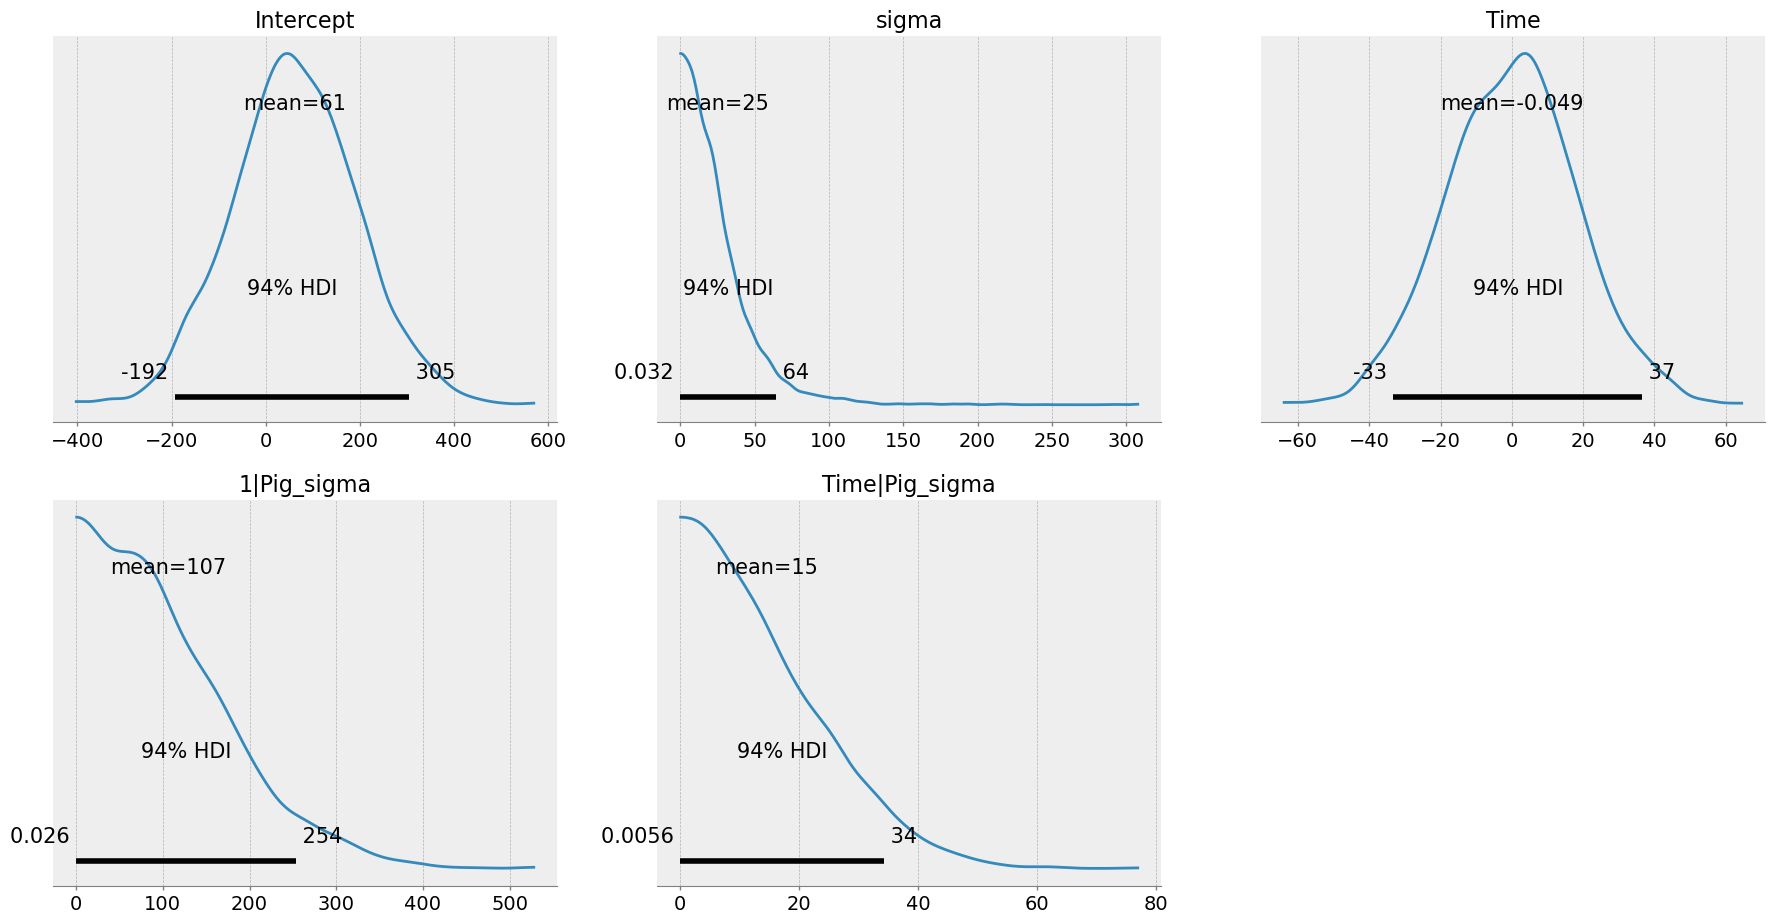

In [9]:
bmb_model.plot_priors();

Both models are literally the same. Take a moment to inspect and compare the graphical representation of both models using `bmb_model.graph()` and `pymc_model.to_graphviz()` . It will help to understand how the parameters in Bambi are related to our mathematical (or PyMC) representation.

## Forest Plots

Now we are ready to check the results. We can get credible interval plots from Forest plots using ArviZ. Here, the line indicates a 94% credible interval calculated as higher posterior density, the thicker line represents the interquartile range, and the dot is the median. We also made a comparison between a few parameters in the same plot. We can quickly note a few things:

 - Both the models ended up in the same posterior because they were structured identically, even with different prior distributions.
 - Also, in both models, we used weakly informative priors, which means these priors don't exert much influence on posteriors, and the observed data drove us to the same inference.
 - The uncertainty about the intercept estimate is much higher than the uncertainty about the `Time` slope.
 - The credible interval for `Time` is far from 0, so we can be confident there's a positive relationship between the `Weight` of the pigs and `Time`.  

We're not making any great discoveries by stating that, as time passes, we expect the pigs to weigh more. Still, this very simple example can be used as a starting point in applications where the relationship between the variables is not that clear beforehand.


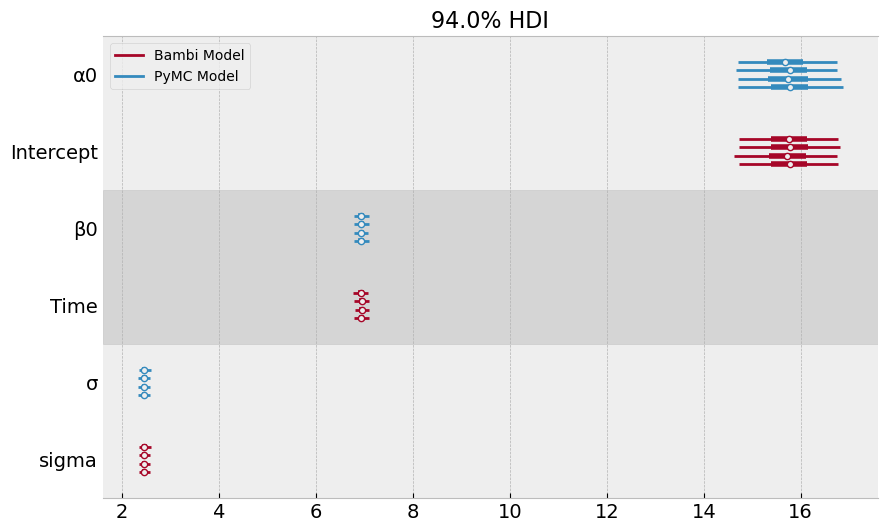

In [10]:
az.plot_forest([pymc_idata, bmb_idata],
               model_names=['PyMC Model', 'Bambi Model'],
               var_names=['α0','Intercept','β0','Time','σ','sigma'],
               figsize=[10,6]);

Since we've ensured both models are identical, we will move forward with Bambi inference only. But feel free to play with PyMC too, if you prefer!

## Trace Plots

Using `az.plot_trace()` we get traceplots that show the values sampled from the posteriors and density estimates that gives us an idea of the shape of the posterior distribution of our parameters. 

In this case it is very convenient to use `compact=True`. We tell ArviZ to plot all the group specific posteriors in the same panel which saves space and makes it easier to compare group specific posteriors. Thus, we'll have a panel with all the group specific intercepts, and another panel with all the group specific slopes. If we used `compact=False`, which is the default, we would end up with a huge number of panels which would make the plot unreadable.

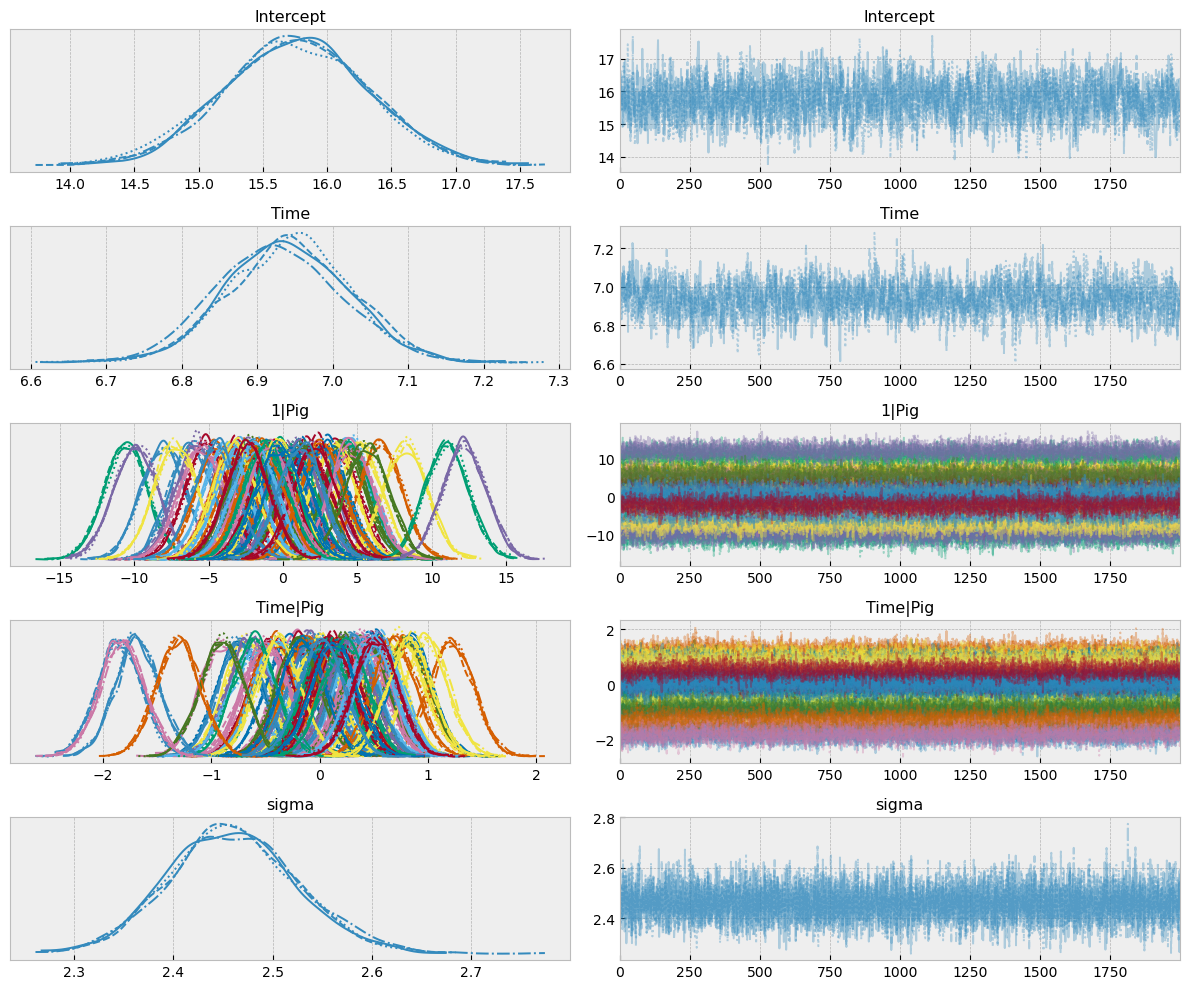

In [11]:
# Plot posteriors
az.plot_trace(
    bmb_idata,
    var_names=['Intercept', 'Time', '1|Pig', 'Time|Pig', 'sigma'],
    compact=True,
);
plt.tight_layout()

The same plot could have been generated with less typing by calling 

`az.plot_trace(results, var_names=["~1|Pig_sigma", "~Time|Pig_sigma"], compact=True);`

which uses an alternative notation to pass `var_names` based on the negation symbol in Python, `~`. There we are telling ArviZ to plot all the variables in the InferenceData object `results`, except from `1|Pig_sigma` and `Time|Pig_sigma`. 

Can't believe it? Come on, run this notebook on your side and have a try! 

## Posterior Summary

The plots generated by `az.plot_trace()` are enough to be confident that the sampler did a good job and conclude about plausible values for the distribution of each parameter in the model. But if we want to, and it is a good idea to do it, we can get numerical summaries for the posteriors with `az.summary()`.

Also you could try comparing this with PyMC model's summary!

In [12]:
az.summary(bmb_idata, kind='stats', 
           var_names=['Intercept', 'Time', '1|Pig_sigma', 'Time|Pig_sigma', 'sigma'])

,mean,sd,hdi_3%,hdi_97%
Intercept,15.751,0.558,14.677,16.760
Time,6.938,0.082,6.788,7.093
1|Pig_sigma,4.538,0.423,3.769,5.329
Time|Pig_sigma,0.662,0.062,0.550,0.783
sigma,2.460,0.064,2.343,2.584


## Estimated regression line

Here we'll visualise the regression equations we have sampled for a few particular pigs, and then we'll compare the mean regression equation for all 72 pigs in the dataset.  

The following plot shows the 8000 (4 chains x 2000 draws each) linear regressions for 10 random pigs, the same pigs previously plotted in the EDA. The mean regression line is plotted in black, and the dark red dots represent the observed weights for this pig.

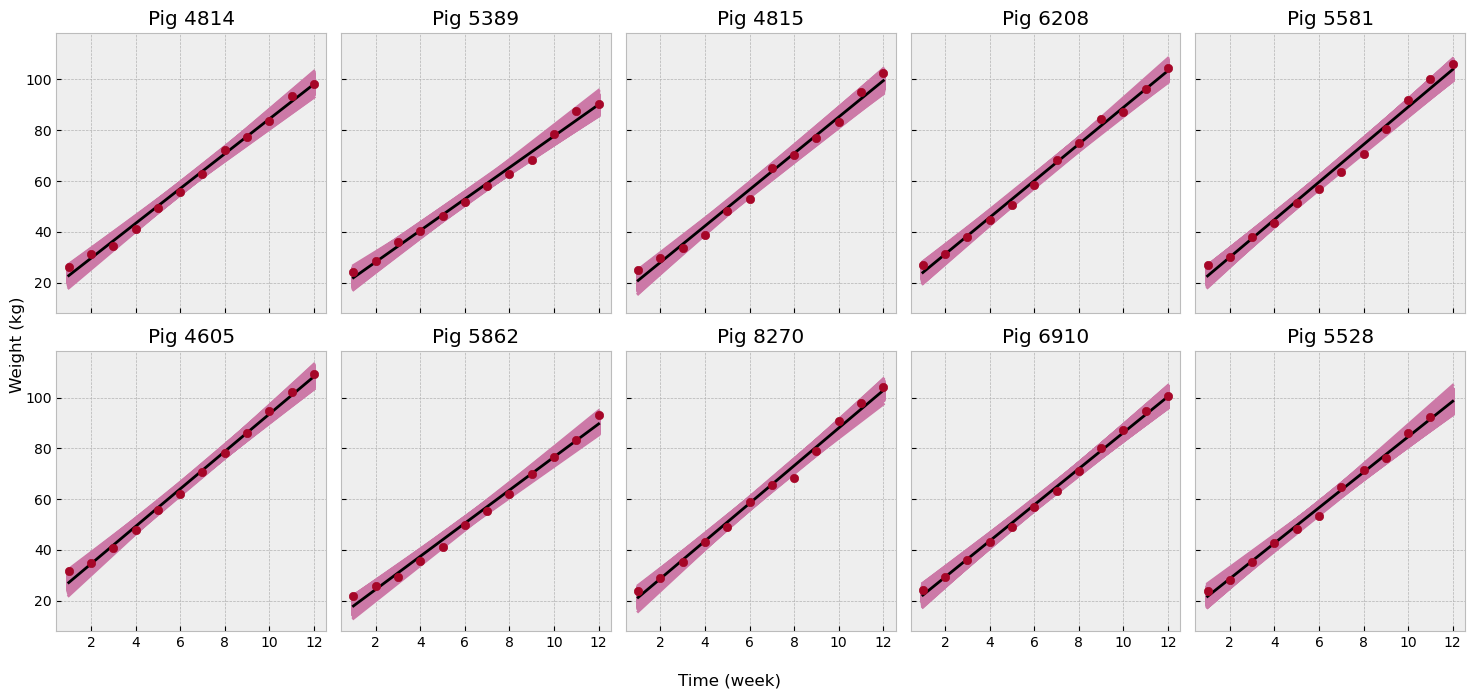

In [13]:
posterior = az.extract(bmb_idata)
α0 = posterior['Intercept']
β0 = posterior['Time']
α1i = posterior['1|Pig']
β1i = posterior['Time|Pig']

time = xr.DataArray(np.array([1, 12]))

fig, axes = plt.subplots(2, 5, figsize=(15,7), sharex=True, sharey=True)
axes = axes.flatten()

for i, pig_id in enumerate(random_pigs):
    pig_data = df[df['Pig'] == pig_id]
    α1 = α1i.sel(Pig__factor_dim=str(pig_id))
    β1 = β1i.sel(Pig__factor_dim=str(pig_id))
    α = α0 + α1
    β = β0 + β1
    axes[i].plot(time, (α + β * time).T, color='C5')                            # Sampled 8000 regression lines
    axes[i].plot(time, α.mean() + β.mean() * time, color='black')               # Mean regression line
    axes[i].scatter(pig_data['Time'], pig_data['Weight'], color='C1',zorder=10) # Observed weights
    axes[i].set_title(f'Pig {pig_id}')
    axes[i].set_xticks([q+1 for q in range(1,13,2)])
fig.supxlabel('Time (week)')
fig.supylabel('Weight (kg)')
plt.tight_layout()
plt.show()

Next, we calculate the mean regression line for each pig and show them together in one plot. Here we clearly see each pig has a different pair of intercept and slope.

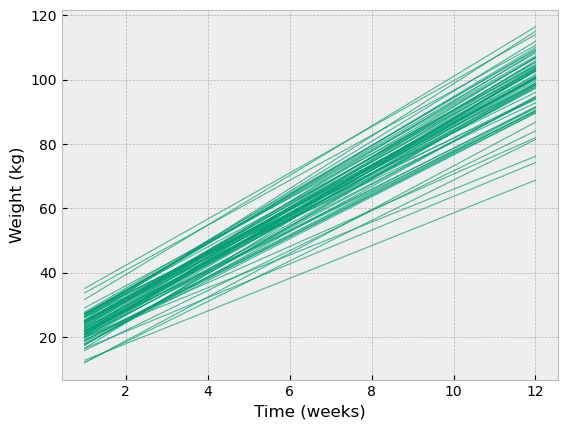

In [14]:
α_mean = α0.mean() + α1i.mean("sample")
β_mean = β0.mean() + β1i.mean("sample")

plt.plot(time, (α_mean + β_mean * time).T, color="C7", alpha=0.7, lw=0.8)
plt.ylabel("Weight (kg)")
plt.xlabel("Time (weeks)");

We can also plot the posterior overlaid with a region of practical equivalence (ROPE). This region indicates a range of parameter values that are considered to be practically equivalent to some reference value of interest to the particular application, for example 0. In the following plot we can see that all our posterior distributions fall outside of this range.

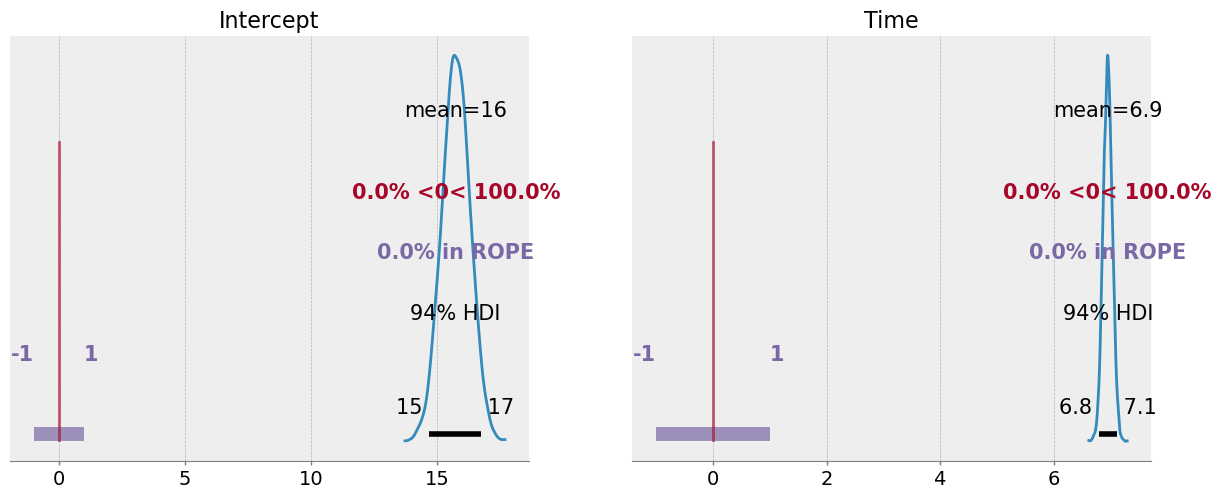

In [15]:
az.plot_posterior(bmb_idata, var_names=["Intercept", "Time"], ref_val=0, rope=[-1, 1]);

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Oct 27 2025

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.6.0

arviz      : 0.22.0
matplotlib : 3.10.7
numpy      : 2.3.4
statsmodels: 0.14.5
xarray     : 2025.10.1
bambi      : 0.1.dev867+g656a0cfbf.d20251027
pymc       : 5.26.1

Watermark: 2.5.0

